<a href="https://colab.research.google.com/github/SaumilShah-7/Dog-Breed-Identification-Kaggle/blob/master/Dog_Breed_Identification_Kaggle_(using_Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.applications import ResNet50
from matplotlib import pyplot
from zipfile import ZipFile
import cv2

TensorFlow 2.x selected.
2.0.0-rc2


In [3]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (8).json


In [4]:
!kaggle competitions download -c dog-breed-identification

labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
with ZipFile('train.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('test.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('labels.csv.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('labels.csv.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('sample_submission.csv.zip', 'r') as zipobj:
  zipobj.extractall()

In [0]:
y_df = pd.read_csv('labels.csv')

# print(y_df['breed'].value_counts())

y_breed = np.asarray(y_df['breed']).reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y_breed)

labels_mapping = {np.argmax(y[i]): y_df.loc[i,'breed'] for i in range(len(y))}

image_height = 128
image_width = 128

x = []
for i in y_df['id']:
  image = cv2.imread('/content/train/'+i+'.jpg')
  x.append(cv2.resize(image, (image_height, image_width)))
x = np.asarray(x)

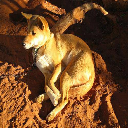

(128, 128, 3) ['dingo']


In [7]:
from google.colab.patches import cv2_imshow

cv2_imshow(x[1])
print(x[1].shape, y_breed[1])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=7, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9199, 128, 128, 3) (1023, 128, 128, 3) (9199, 120) (1023, 120)


In [9]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(image_width, image_height, 3))
x_train_tl = base_model.predict(x_train)
x_test_tl = base_model.predict(x_test)
print(x_train_tl.shape, x_test_tl.shape)

(9199, 4, 4, 2048) (1023, 4, 4, 2048)


In [0]:
mean = np.mean(x_train_tl, axis=0)
std_dev = np.std(x_train_tl, axis=0)

x_train_tl = x_train_tl.astype(np.float64)
x_test_tl = x_test_tl.astype(np.float64)

x_train_tl-=mean
x_train_tl/=std_dev

x_test_tl-=mean
x_test_tl/=std_dev

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(np.size(x_train_tl, axis=1), np.size(x_train_tl, axis=2), np.size(x_train_tl, axis=3))))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=240, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=120, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
dropout_7 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              32769000  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 240)               240240    
_________________________________________________________________
dropout_9 (Dropout)          (None, 240)              

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
8704/9199 [===========================>..] - ETA: 0s - loss: 4.4968 - accuracy: 0.1176
Epoch 00001: val_accuracy improved from -inf to 0.26784, saving model to best_model.h5
9199/9199 [==============================] - 4s 469us/sample - loss: 4.4616 - accuracy: 0.1210 - val_loss: 3.3222 - val_accuracy: 0.2678
Epoch 2/50
8704/9199 [===========================>..] - ETA: 0s - loss: 2.6418 - accuracy: 0.3807
Epoch 00002: val_accuracy improved from 0.26784 to 0.36950, saving model to best_model.h5
9199/9199 [==============================] - 3s 368us/sample - loss: 2.6295 - accuracy: 0.3836 - val_loss: 2.6764 - val_accuracy: 0.3695
Epoch 3/50
8704/9199 [===========================>..] - ETA: 0s - loss: 1.7559 - accuracy: 0.5508
Epoch 00003: val_accuracy improved from 0.36950 to 0.39687, saving model to best_model.h5
9199/9199 [==============================] - 3s 379us/sample - loss: 1.7482 - accuracy: 0.5538 - val_loss: 2.5608 - v

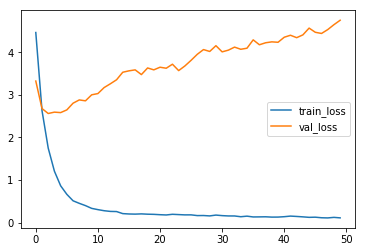

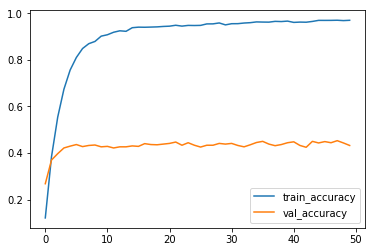

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train_tl, y_train, batch_size=512, epochs=50, validation_data=(x_test_tl, y_test), callbacks=[es, mc])
saved_model = load_model('best_model.h5')

pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.legend()
pyplot.show()

pyplot.plot(history.history['accuracy'], label='train_accuracy')
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.legend()
pyplot.show()

In [0]:
y_test_pred = saved_model.predict(x_test_tl)
y_test_pred_id = np.argmax(y_test_pred, axis=1).reshape(-1, 1)
y_test_id = np.argmax(y_test, axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(confusion_matrix(y_test_id, y_test_pred_id), index=[labels_mapping[i] for i in range(len(labels_mapping))], 
                                            columns=[labels_mapping[i] for i in range(len(labels_mapping))])

# import seaborn as sn
# pyplot.figure(figsize=(20,7))
# sn.heatmap(df_cm, annot=True)